In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV,ParameterGrid,cross_val_score,learning_curve
from sklearn.pipeline import make_pipeline,Pipeline

import matplotlib.pyplot as plt


In [ ]:
x_train = pd.read_csv('data_source/X_train.csv')
y_train = pd.read_csv('data_source/y_train.csv')

x_test = pd.read_csv('data_source/X_test.csv')
y_test = pd.read_csv('data_source/y_test.csv')


x_train_robust = x_train.copy()
y_train_robust = y_train.copy()

x_test_robust = x_test.copy()
y_test_robust = y_test.copy()


x_train_robust = x_train_robust.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_train_robust = y_train_robust.loc[:,'Action']
x_test_robust = x_test_robust.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_test_robust = y_test_robust.loc[:,'Action']

In [ ]:
robust = RobustScaler()

x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']] = robust.fit_transform(x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']])
x_test_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']] = robust.fit_transform(x_test_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']])

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', KNeighborsClassifier()) # object='multi:softmax',num_class=4,seed=42,eval_metric='merror'
])

In [ ]:
parameters = [{'classifier__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],'classifier__weights':['uniform', 'distance'],'classifier__algorithm':['auto', 'ball_tree']},
]

In [21]:
grid = GridSearchCV(pipe,parameters,cv=5)
grid.fit(x_train_robust, y_train_robust)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Best parameter (CV score=0.968):
{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier', KNeighborsClassifier())])


In [18]:
pipe.set_params(classifier__algorithm='auto', classifier__n_neighbors = 9, classifier__weights = 'distance')

Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=9, weights='distance'))])

In [19]:
train_sizes, train_scores, test_scores = learning_curve(pipe, x_train_robust, y_train_robust, cv=5,scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

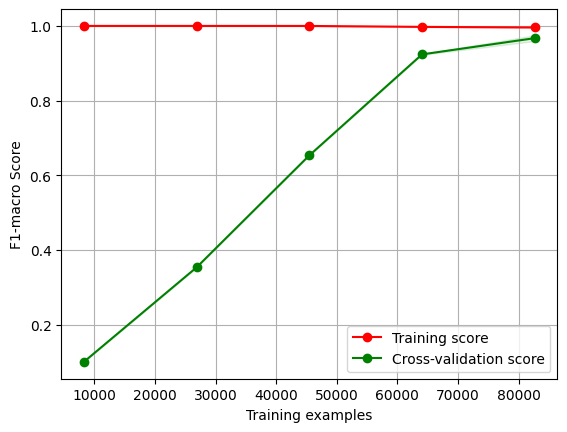

In [20]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("F1-macro Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")